# Animal Pose Estimation

In [59]:
import os
import torch
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
import gdown
from clearml import Task
from ultralytics import YOLO


# personal modules
from src.dataset import *

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_on_gpu = torch.cuda.is_available()

## 1. Dataset and Dataloader

In [ ]:
!mkdir Dataset
!gdown "https://drive.google.com/drive/folders/1xxm6ZjfsDSmv6C9JvbgiGrmHktrUjV5x" -O Dataset --folder
!unzip Dataset/images.zip -d Dataset
!mkdir -p Dataset\labels
!mkdir -p Dataset\images\train Dataset\images\val Dataset\images\test Dataset\labels\train Dataset\labels\val Dataset\labels\test

In [9]:
dataset = AnimalPoseDataset(json_file='Dataset/keypoints.json', 
                            root_dir='Dataset/images/',
                            transform=transforms.Compose([Rescale((640,640))]))
                                                        
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
sample = {'image_id':None, 'image': None, 'keypoints': None, 'bbox':None, 'label':None}


In [14]:
for i_batch, sample_batched in enumerate(dataloader):
    if i_batch == 3:
        sample['image_id'] = sample_batched['image_id']
        sample['image'] = sample_batched['image']
        sample['keypoints'] = sample_batched['keypoints']
        sample['bbox'] = sample_batched['bbox']
        sample['label'] = sample_batched['label']
        break

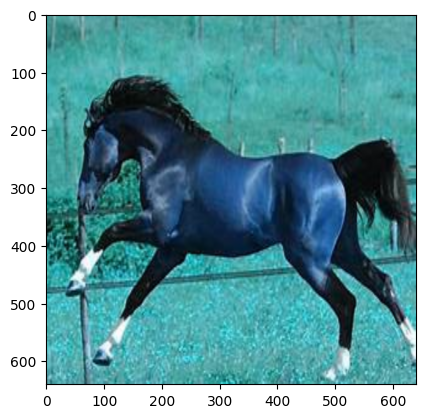

ValueError: not enough values to unpack (expected 4, got 1)

In [60]:
# show image
plt.figure()
#convert bgr to rgb
plt.imshow(sample['image'][0])
plt.show()

# show keypoints
img = dataset.draw(sample)
plt.figure()
plt.imshow()
plt.show()
